In [3]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
sns.color_palette("colorblind")

from vafator.power import PowerCalculator
from vafator.ploidies import PloidyManager

## Data generation

We simulate a comprehensive dataset for a given set of possible purity and tumor ploidy values over different coverage values from 1x to 100x.

In [7]:
purities = {'01': 0.1, '02': 0.2, '03': 0.3, '04': 0.4, '05': 0.5, '06': 0.6, '07': 0.7, '08': 0.8, '09': 0.9, '10': 1.0}
samples = list(purities.keys())
ploidies = [PloidyManager(genome_wide_ploidy=float(ploidy)) for ploidy in [1, 2, 3, 4, 5, 6]]
coverages = list(range(1, 100))  # 200

### Compute the probability of observing AC reads or less by chance

In [48]:
dfs= []
for ploidy in ploidies:
    power = PowerCalculator(
        purities=purities,
        tumor_ploidies= {s: ploidy for s in purities.keys()}
    )
    
    data = []
    for s in samples:
        for dp in coverages:
            for ac in range(0, int(dp)):
                pvalue = power.calculate_power(sample=s, dp=dp, ac=ac, variant=None)
                eaf = power.calculate_expected_vaf(sample=s, variant=None)
                data.append([power.purities.get(s), dp, ac, round(pvalue, 3), eaf])

    df = pd.DataFrame(data, columns=['purity', 'dp', 'ac', 'pvalue', 'eaf'])
    df['ploidy'] = ploidy.ploidy
    dfs.append(df)

data_probabilities = pd.concat(dfs)
data_probabilities.to_csv("data_probabilities.tsv", sep='\t', index=False)

### Compute the absolute power

In [22]:
x_labels = [3, 4, 5]
y_labels = [0, 3]

dfs = []

for error_rate in [0.001, 0.003, 0.08, 0.15]:
    
    for ploidy in ploidies:
        power = PowerCalculator(
            purities=purities,
            tumor_ploidies= {s: ploidy for s in purities.keys()},
            error_rate=error_rate
        )

        samples = list(power.purities.keys())
        coverages = list(range(1, 100))  # 200

        data = []
        for s in samples:
            for dp in coverages:
                p, k = power.calculate_absolute_power(sample=s, dp=dp, variant=None)
                data.append([power.purities.get(s), dp, p, k])

        df = pd.DataFrame(data, columns=['purity', 'dp', 'power', 'k'])
        df['ploidy'] = ploidy.ploidy
        df['error_rate'] = error_rate
        dfs.append(df)

data_power = pd.concat(dfs)
data_power.to_csv("data_power.tsv", sep='\t', index=False)

## Plots

### Probability

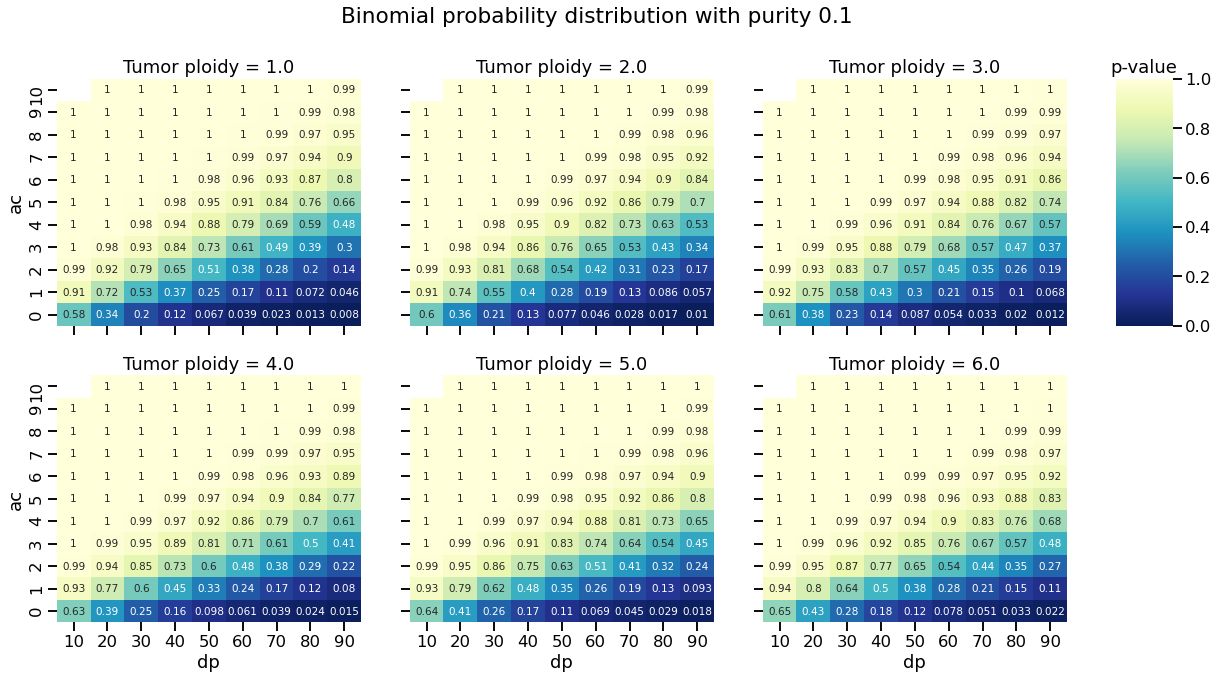

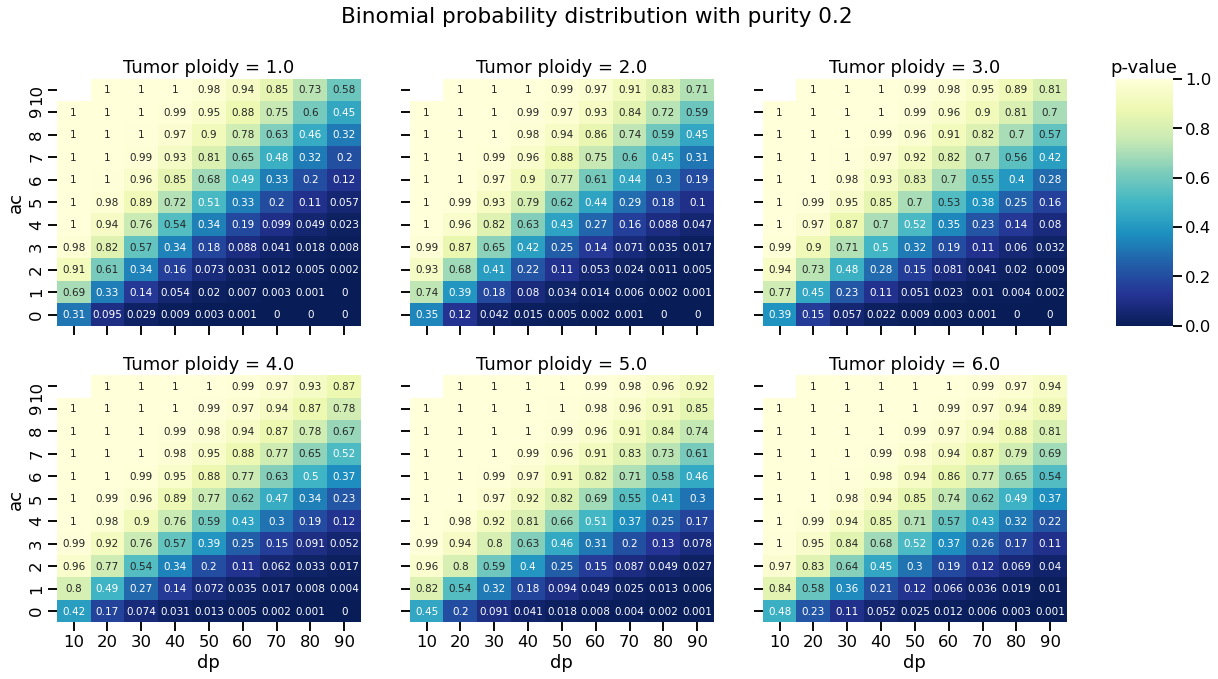

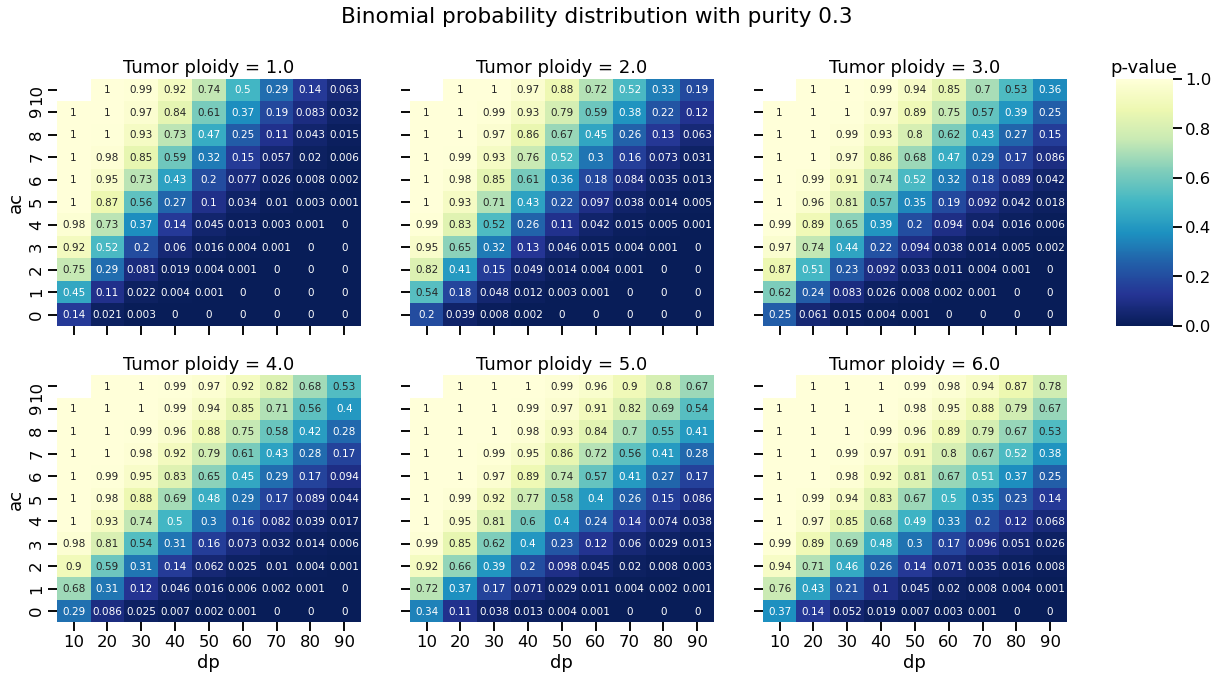

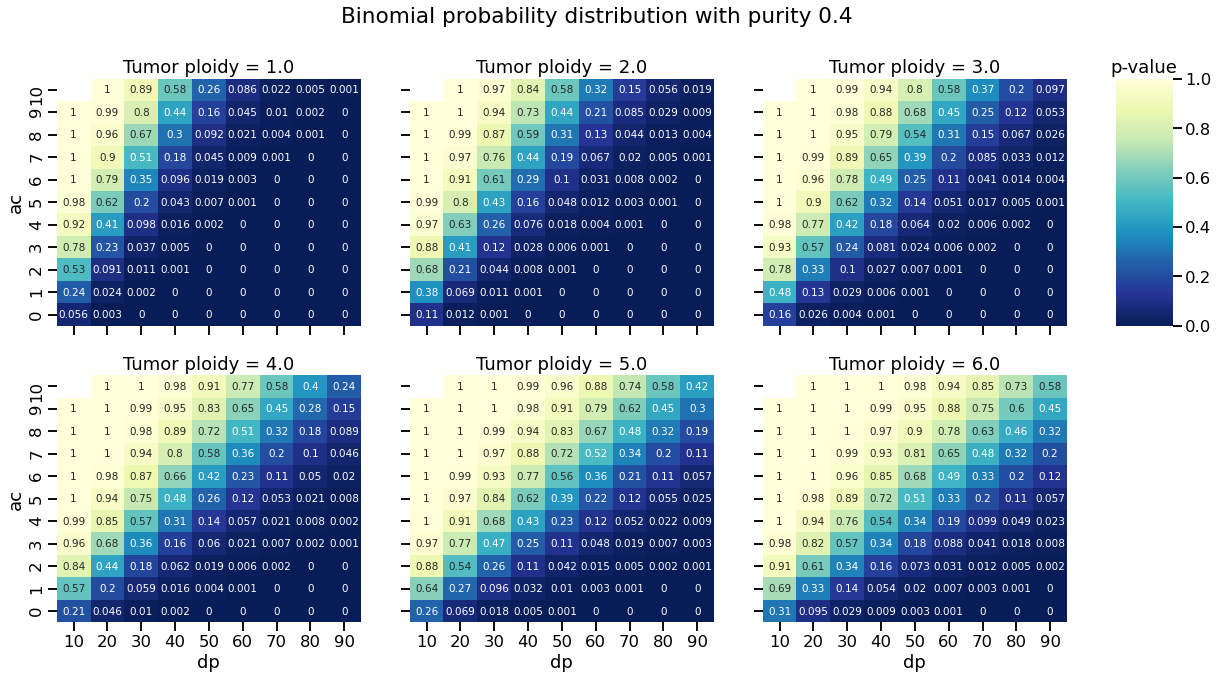

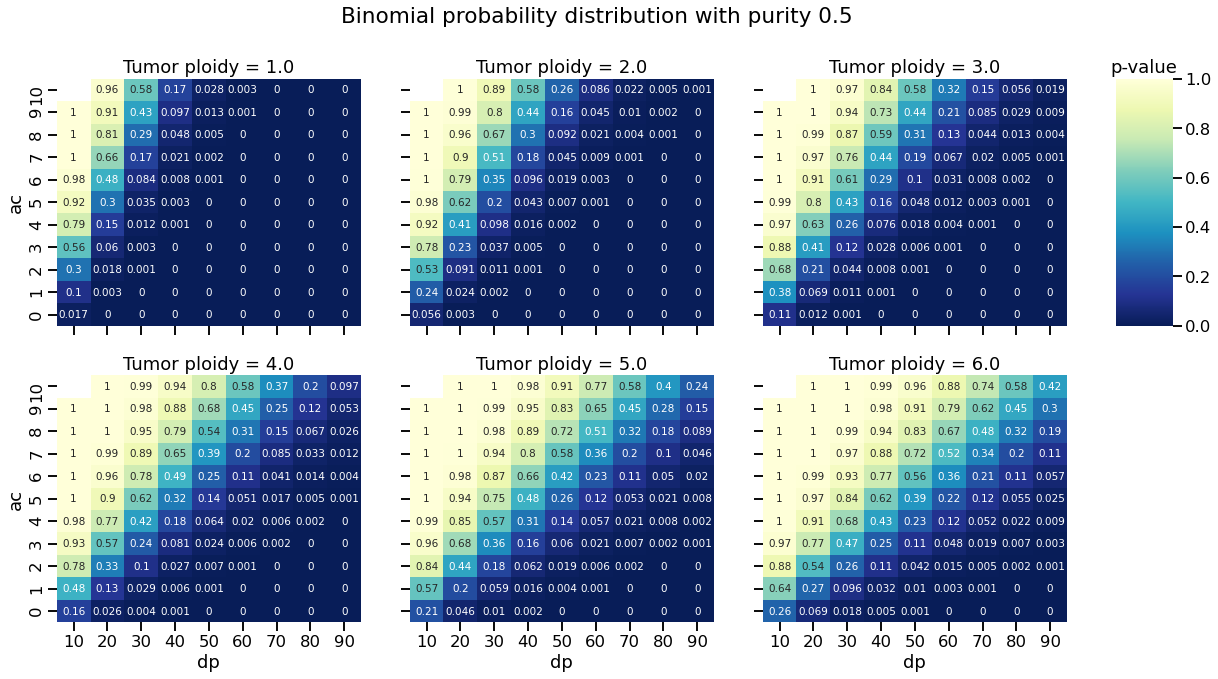

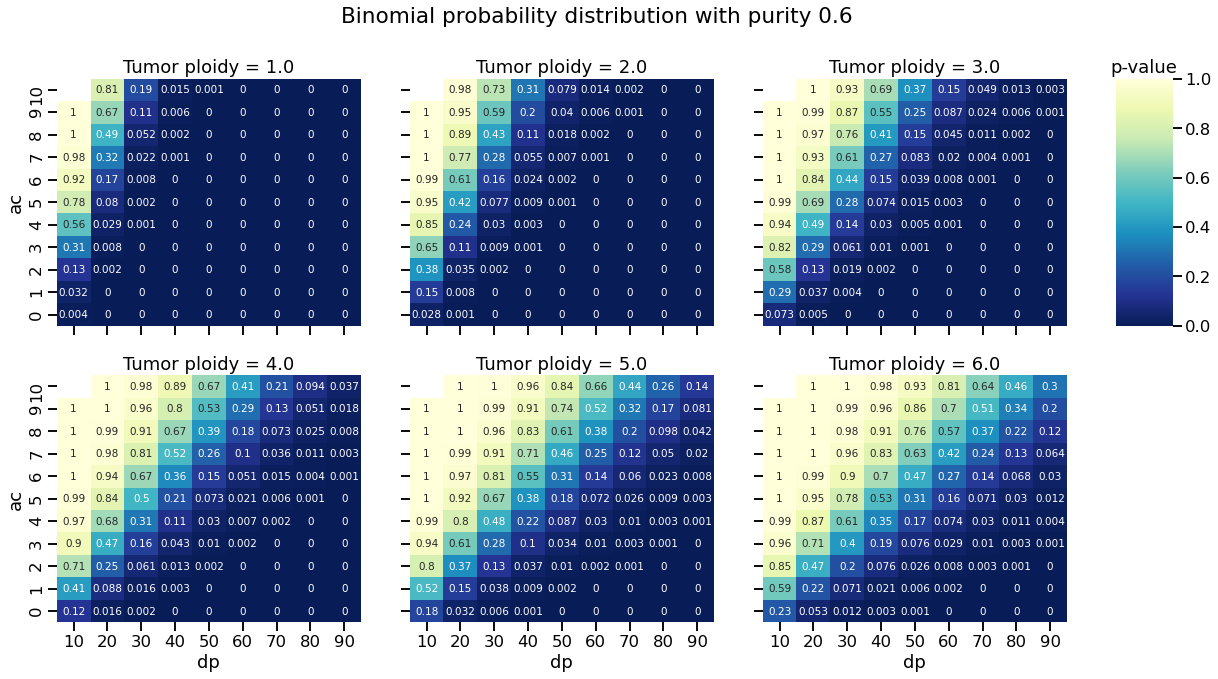

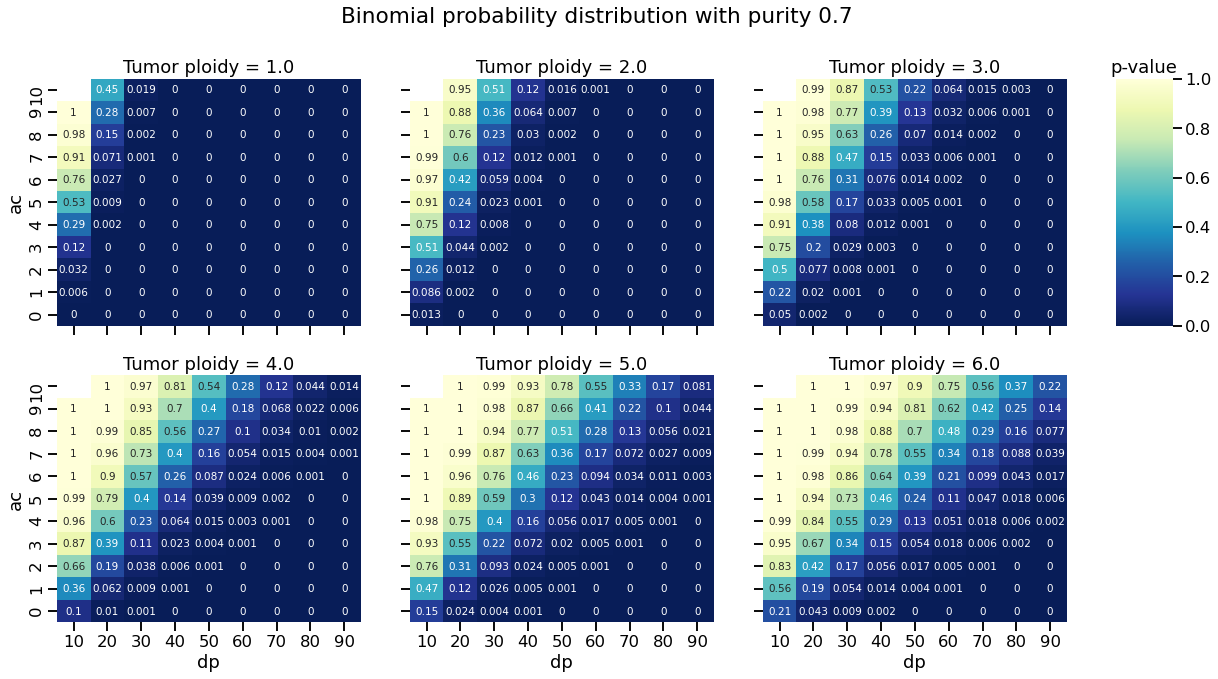

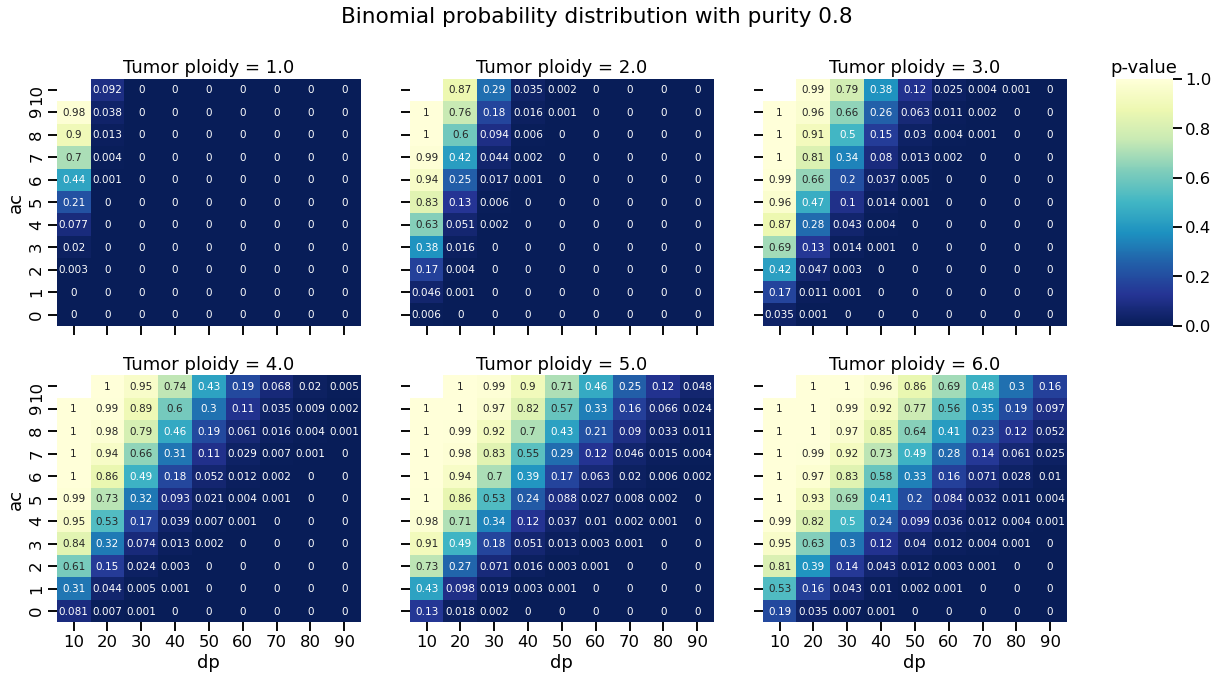

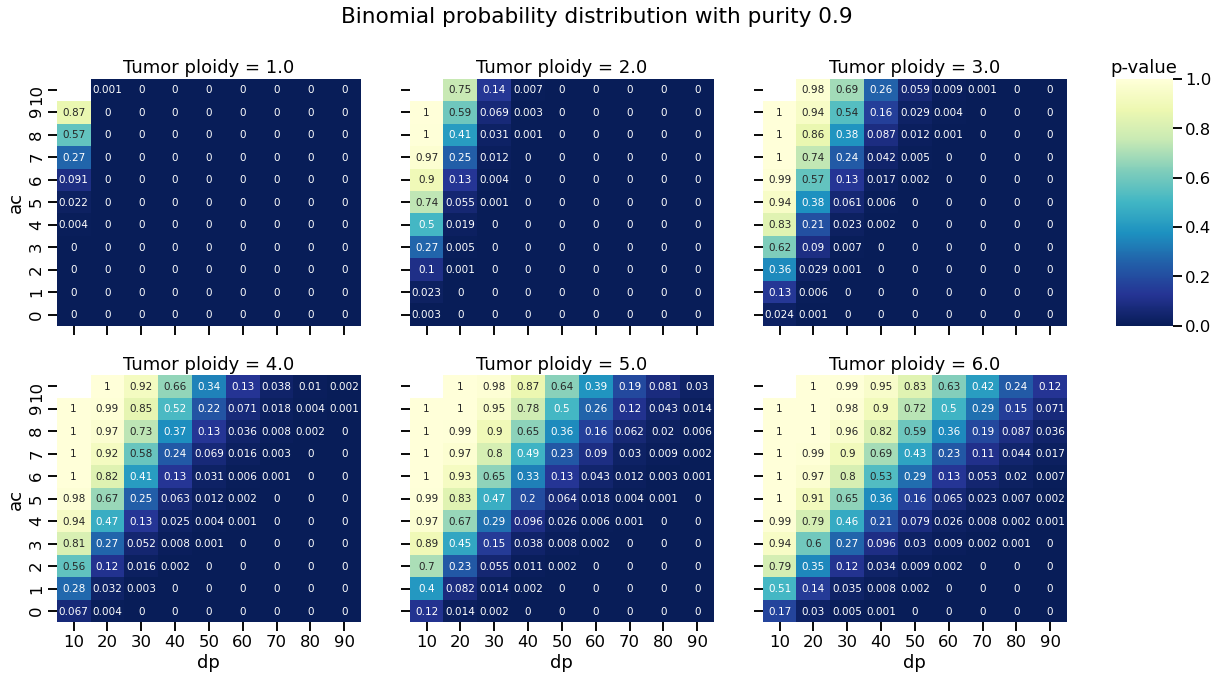

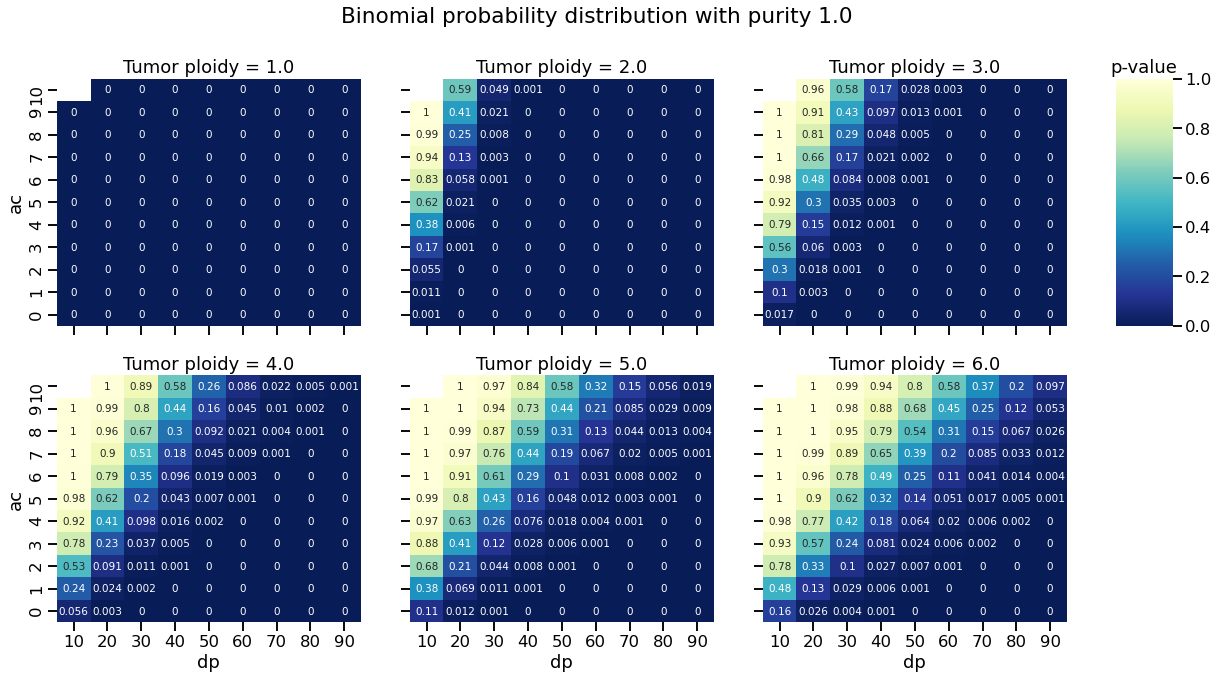

In [49]:
for purity in purities.values():

    fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(20,10), gridspec_kw={'width_ratios': [0.32, 0.32, 0.32, 0.06]})
    # sharex=True, sharey=True, 
    index = 0
    
    cbar_ax = axes.flatten()[3]
    cbar_ax.set_xticks([])
    cbar_ax.set_yticks([])
    cbar_ax.set_title('p-value')
    
    empty_ax = axes.flatten()[7]
    empty_ax.set_xticks([])
    empty_ax.set_yticks([])
    sns.despine(ax=empty_ax, left=True, bottom=True)
    
    for ploidy, ax in zip(data_probabilities.ploidy.unique(), list(axes.flatten()[0:3]) + list(axes.flatten()[4:7])):
        
        df = data_probabilities[(data_probabilities.purity == purity) & 
                                (data_probabilities.ploidy == ploidy) & 
                                (data_probabilities.ac.isin(range(0, 11))) &
                                (data_probabilities.dp.isin(range(10, 101, 10)))]
        
        g = sns.heatmap(data=df.pivot(index='ac', columns='dp', values='pvalue'), 
                    cmap='YlGnBu_r', 
                    ax=ax, 
                    cbar_ax=cbar_ax, 
                    vmin=0.0, 
                    vmax=1.0,
                    annot=True,
                    annot_kws={'fontsize': 'xx-small'}
                   )
        g.invert_yaxis()
            
        ax.set_title("Tumor ploidy = {}".format(ploidy))
        
        if index not in x_labels:
            ax.set_xlabel(None)
            ax.set_xticklabels([])
        else:
            pass
            #ax.set_xticks(np.linspace(10,100,10))
            #ax.set_xticklabels(np.linspace(10,100,10).astype(int))
            
        if index not in y_labels:
            ax.set_ylabel(None)
            ax.set_yticklabels([])
            
        index += 1
        
    plt.suptitle("Binomial probability distribution with purity {}".format(purity))
    plt.savefig("../figures/probability_distribution_purity_{}.png".format(purity), dpi='figure')

### Absolute power

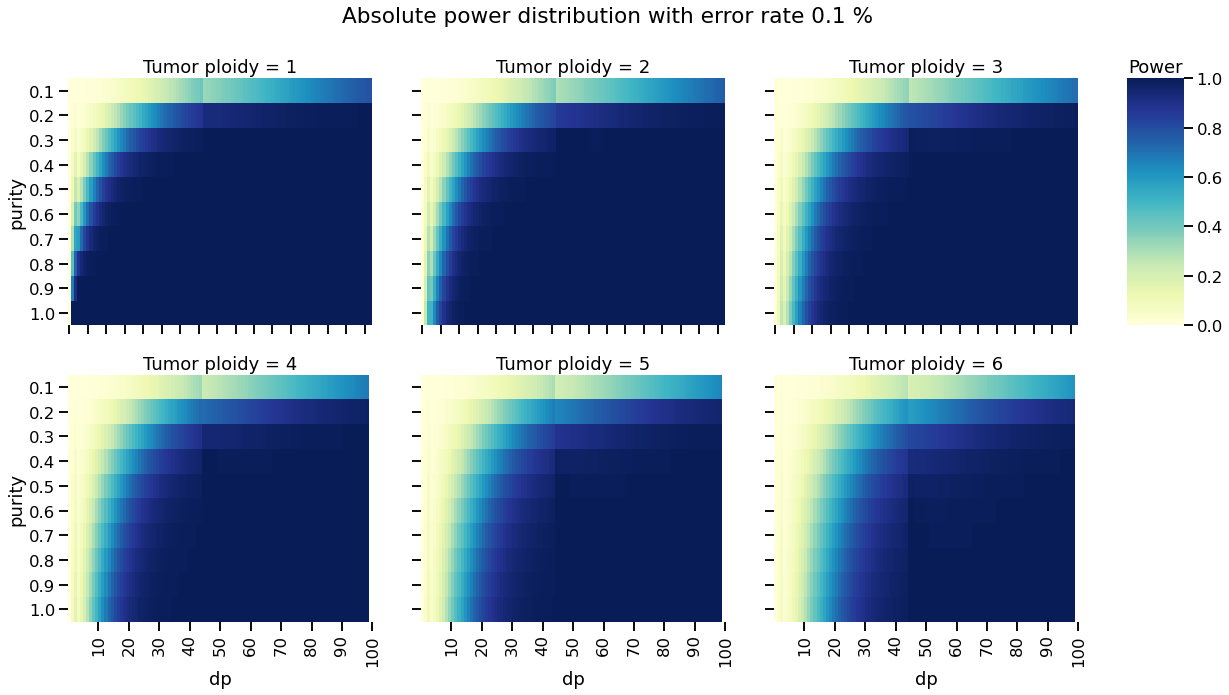

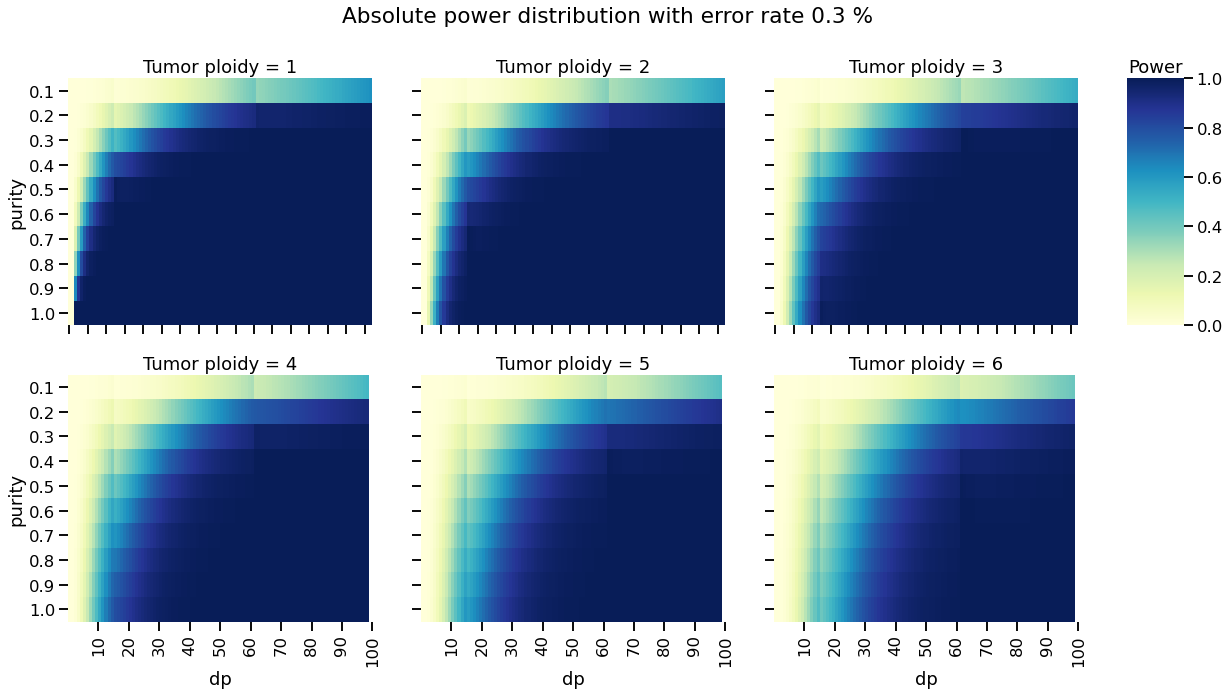

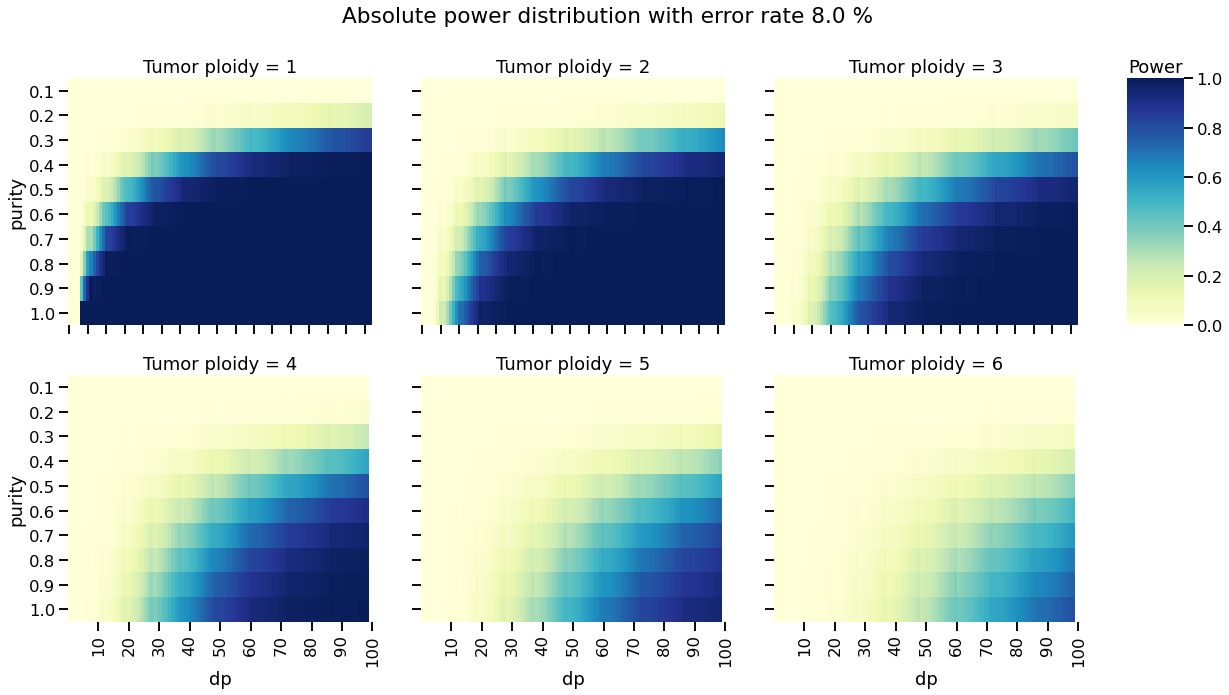

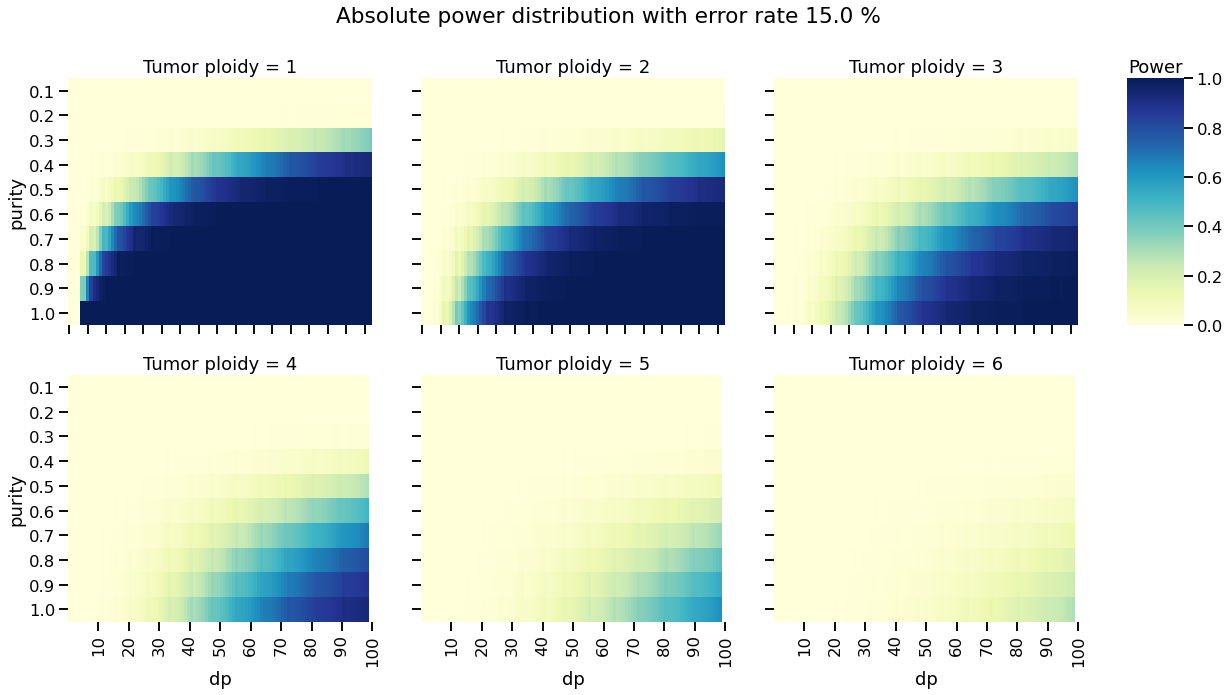

In [64]:
for error_rate in data_power.error_rate.unique():

    fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(20,10), gridspec_kw={'width_ratios': [0.32, 0.32, 0.32, 0.06]})
    # sharex=True, sharey=True, 
    index = 0
    
    cbar_ax = axes.flatten()[3]
    cbar_ax.set_xticks([])
    cbar_ax.set_yticks([])
    cbar_ax.set_title('Power')
    
    empty_ax = axes.flatten()[7]
    empty_ax.set_xticks([])
    empty_ax.set_yticks([])
    sns.despine(ax=empty_ax, left=True, bottom=True)
    
    for ploidy, ax in zip(data_power.ploidy.unique(), list(axes.flatten()[0:3]) + list(axes.flatten()[4:7])):
        
        df = data_power[(data_power.error_rate == error_rate) & (data_power.ploidy == ploidy)]
        
        sns.heatmap(data_power=df.pivot(index='purity', columns='dp', values='power'), 
                    cmap='YlGnBu', 
                    ax=ax, 
                    cbar_ax=cbar_ax, 
                    vmin=0.0, 
                    vmax=1.0
                   )
            
        ax.set_title("Tumor ploidy = {}".format(ploidy))
        
        if index not in x_labels:
            ax.set_xlabel(None)
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.linspace(10,100,10))
            ax.set_xticklabels(np.linspace(10,100,10).astype(int))
            
        if index not in y_labels:
            ax.set_ylabel(None)
            ax.set_yticklabels([])
            
        index += 1
        
    plt.suptitle("Absolute power distribution with error rate {} %".format(error_rate * 100))
    plt.savefig("../figures/power_distribution_error_rate_{}.png".format(error_rate), dpi='figure')

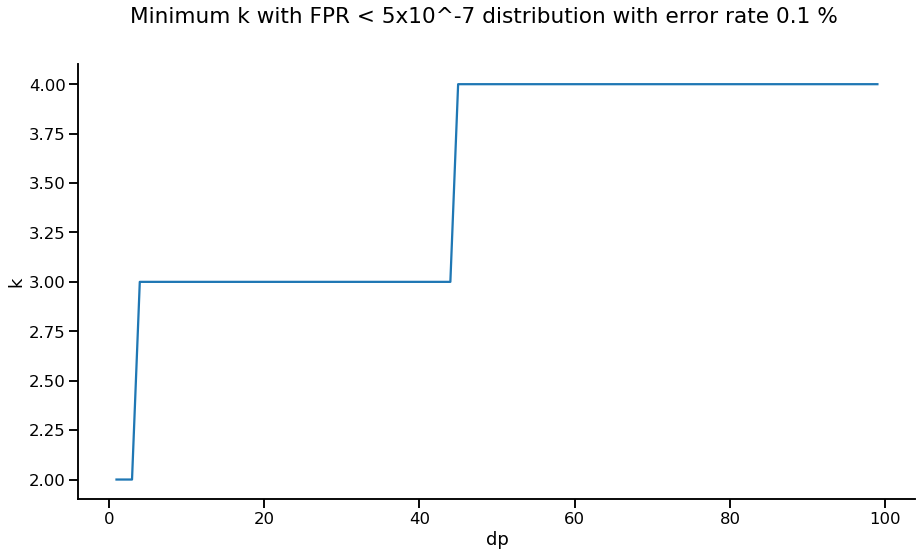

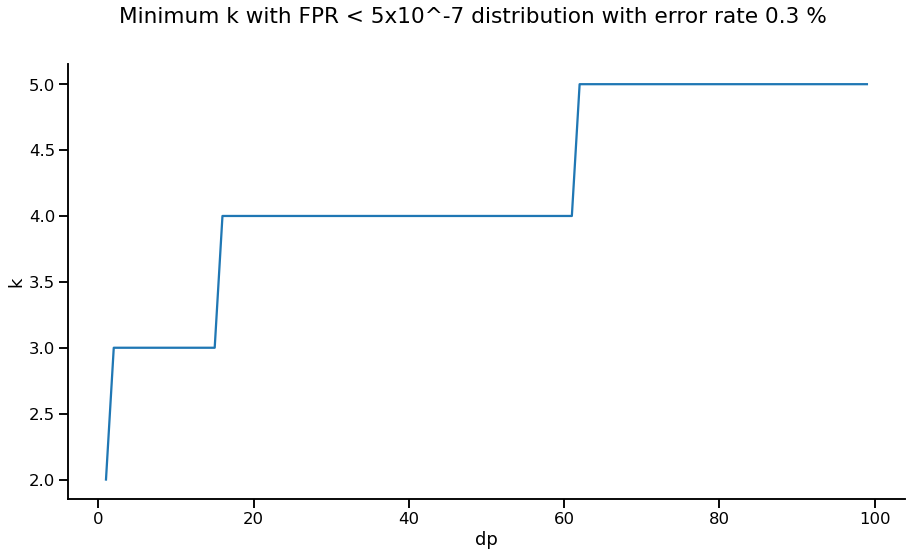

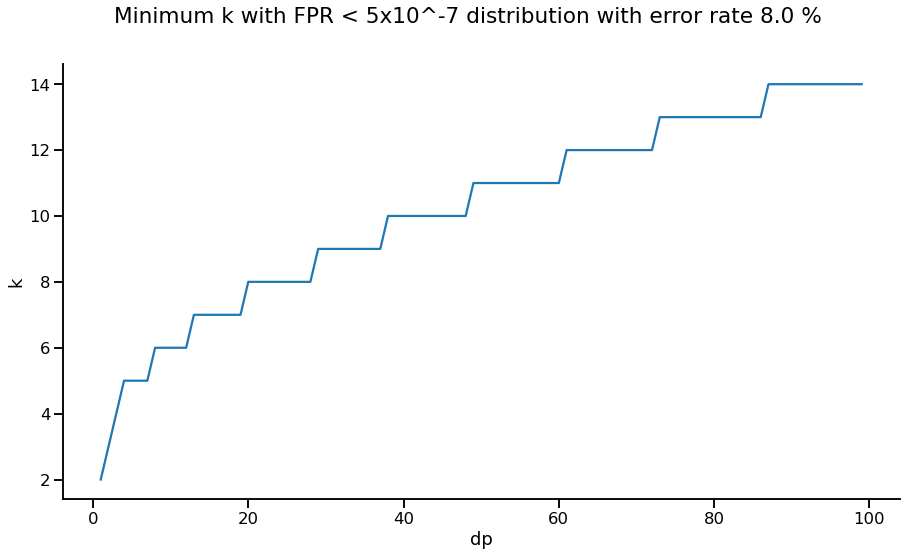

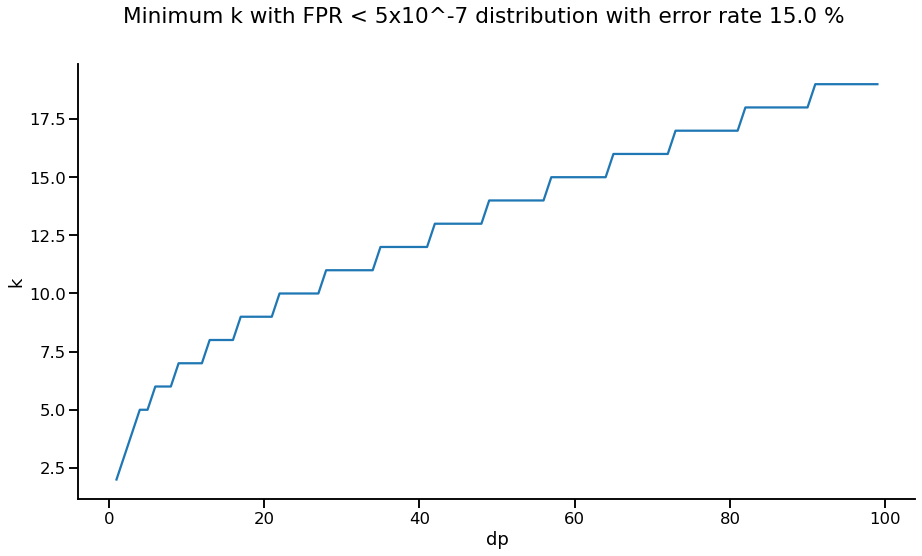

In [71]:
for error_rate in data_power.error_rate.unique():

    fig = plt.figure(figsize=(15,8))
    
    df = data_power[(data_power.error_rate == error_rate) & (data_power.ploidy == 2) & (data_power.purity == 1.0)]
        
    sns.lineplot(data_power=df, x='dp', y=df.k.astype(int))
                                    
    plt.suptitle("Minimum k with FPR < 5x10^-7 distribution with error rate {} %".format(error_rate * 100))
    sns.despine()
    
    plt.savefig("../figures/k_distribution_error_rate_{}.png".format(error_rate), dpi='figure')

### Comparison between binomial probability and absolute power

In [50]:
data_probabilities.head()

,purity,dp,ac,pvalue,eaf,ploidy
0,0.1,1,0,0.947,0.052632,1.0
1,0.1,2,0,0.898,0.052632,1.0
2,0.1,2,1,0.997,0.052632,1.0
3,0.1,3,0,0.850,0.052632,1.0
4,0.1,3,1,0.992,0.052632,1.0


In [51]:
data_power.head()

,purity,dp,power,k,ploidy,error_rate
0,0.1,1,0.00000,2,1.0,0.001
1,0.1,2,0.00277,2,1.0,0.001
2,0.1,3,0.00802,2,1.0,0.001
3,0.1,4,0.00097,3,1.0,0.001
4,0.1,5,0.00193,3,1.0,0.001


In [53]:
data_probabilities.shape

(297000, 6)

In [52]:
data_power[data_power.error_rate == 0.001].shape

(5940, 6)

In [56]:
pd.merge(data_power[data_power.error_rate == 0.001], data_probabilities[data_probabilities.ac == 0], on=['dp', 'purity', 'ploidy'])

,purity,dp,power,k,ploidy,error_rate,ac,pvalue,eaf
0,0.1,1,0.00000,2,1.0,0.001,0,0.947,0.052632
1,0.1,2,0.00277,2,1.0,0.001,0,0.898,0.052632
2,0.1,3,0.00802,2,1.0,0.001,0,0.850,0.052632
3,0.1,4,0.00097,3,1.0,0.001,0,0.806,0.052632
4,0.1,5,0.00193,3,1.0,0.001,0,0.763,0.052632
...,...,...,...,...,...,...,...,...,...
5935,1.0,95,0.99997,4,6.0,0.001,0,0.000,0.166667
5936,1.0,96,0.99998,4,6.0,0.001,0,0.000,0.166667
5937,1.0,97,0.99998,4,6.0,0.001,0,0.000,0.166667
5938,1.0,98,0.99998,4,6.0,0.001,0,0.000,0.166667


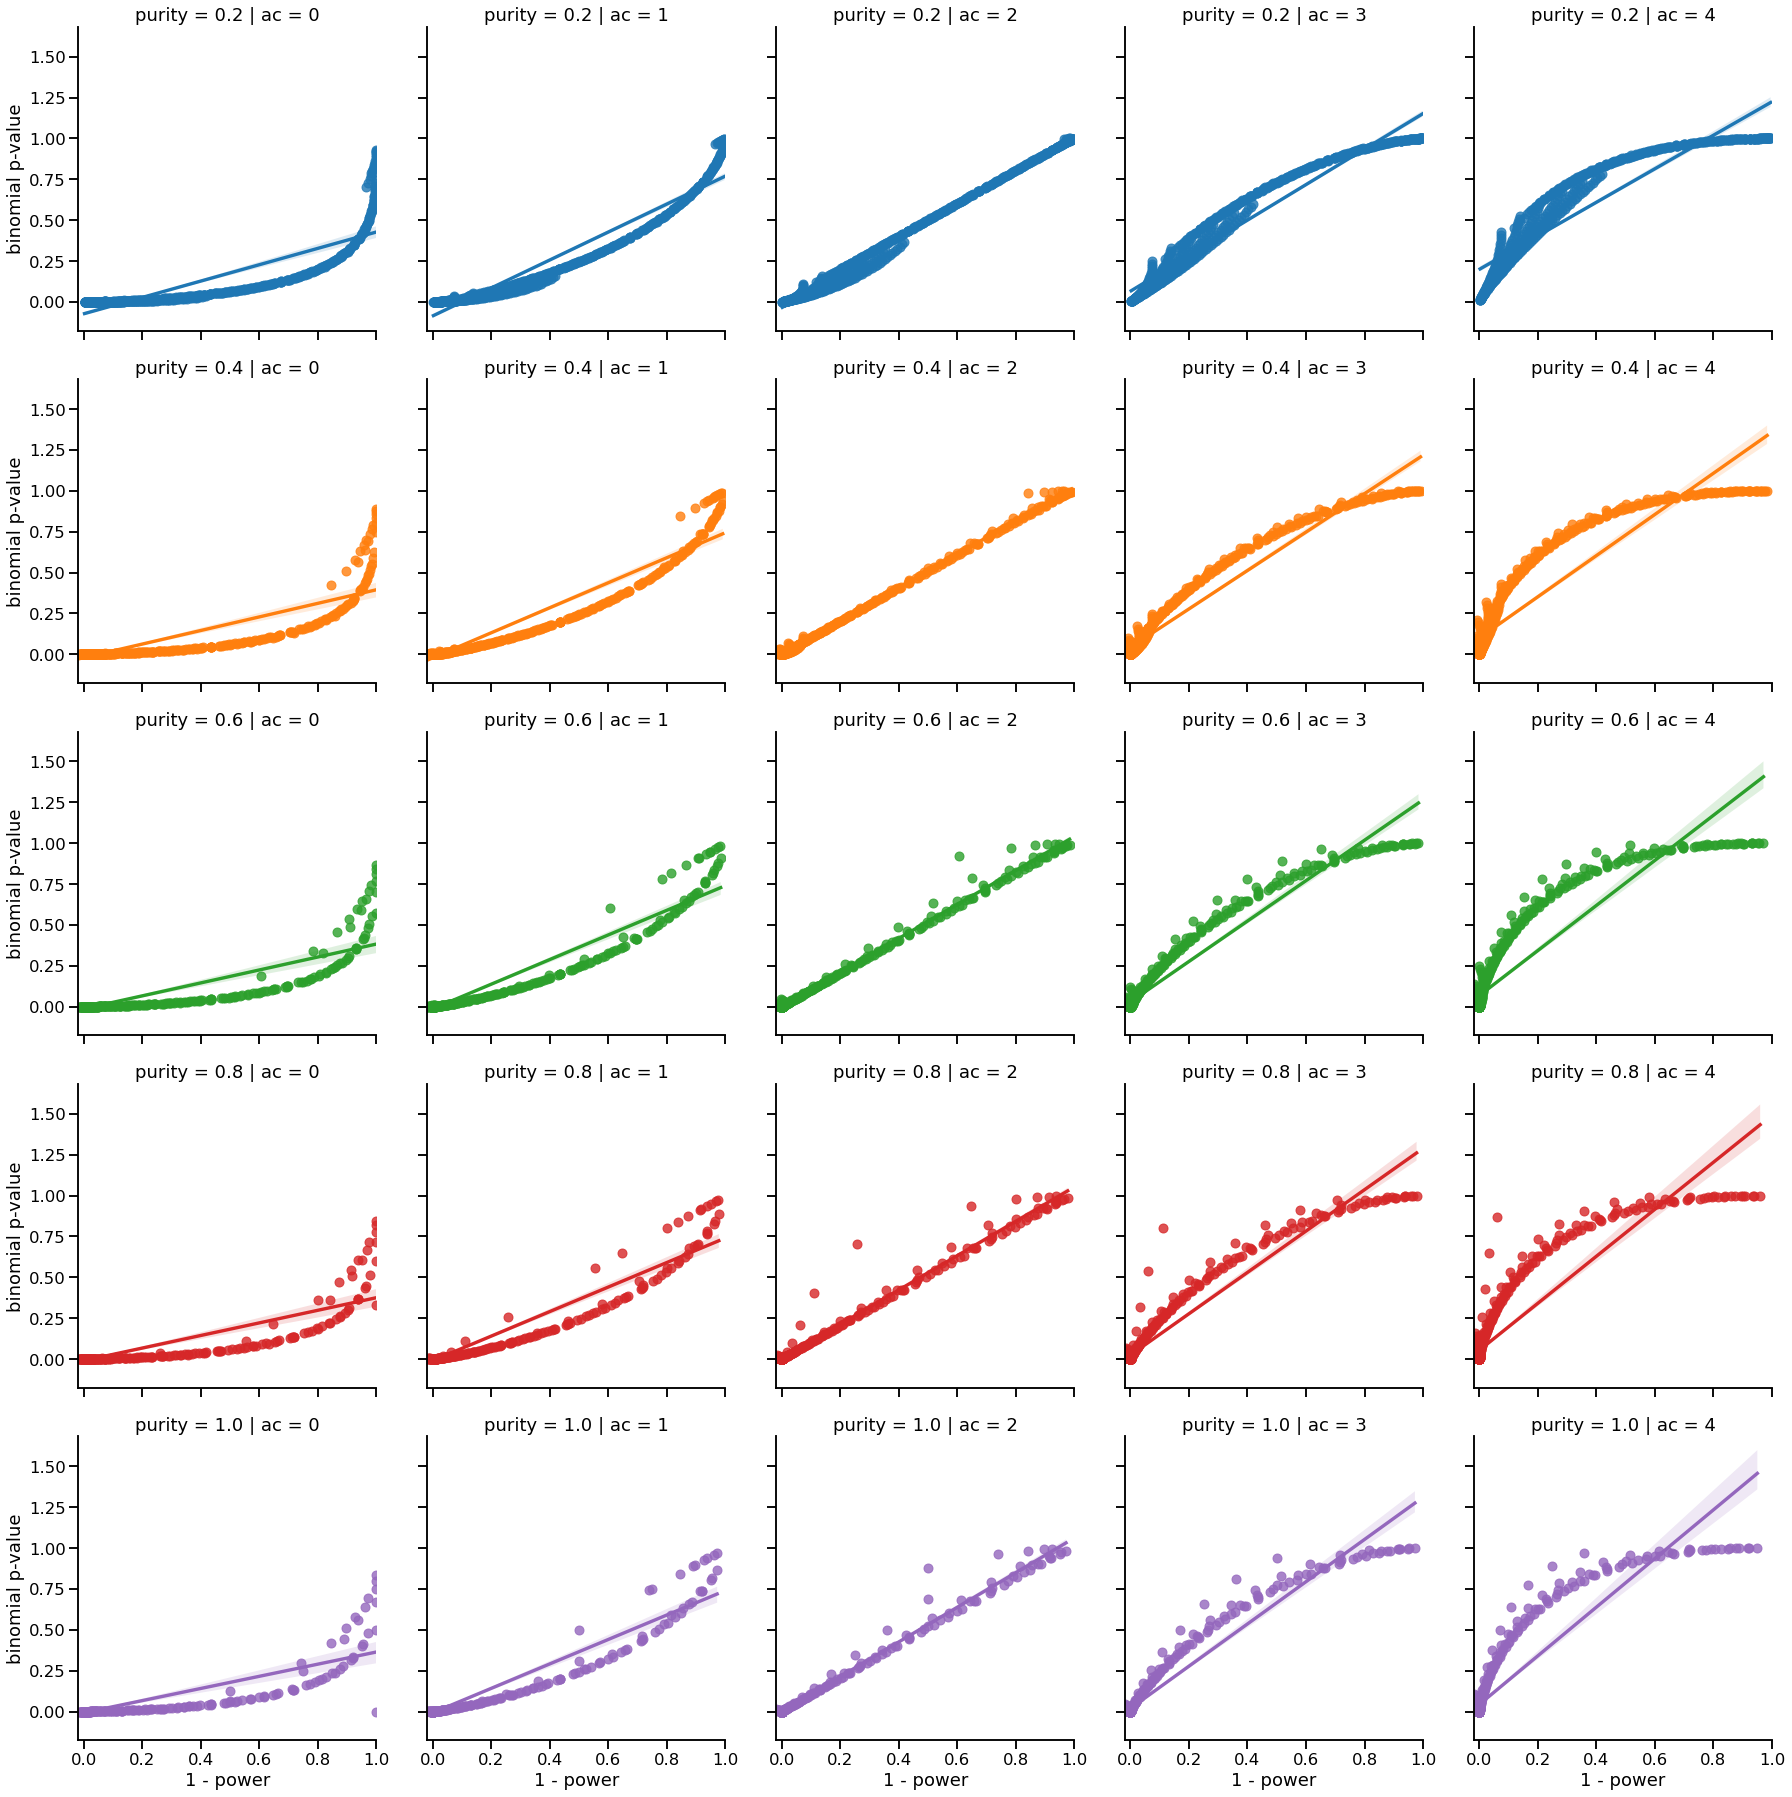

In [73]:
data=pd.merge(data_power[(data_power.error_rate == 0.001)], data_probabilities, on=['dp', 'purity', 'ploidy'])
data = data[(data.ac.isin(range(0, 5))) & (data.purity.isin([.2, .4, .6, .8, 1.0]))]
data['reversed_power'] = data.power.transform(lambda p: 1 - p)

g = sns.lmplot(
    data=data,
    x='reversed_power', 
    y='pvalue',
    hue='purity',
    col='ac',
    #col_wrap=5,
    row='purity'
)
g.set_axis_labels("1 - power", "binomial p-value")
plt.savefig("../figures/comparison_power_probability_lmplot.png", dpi='figure')

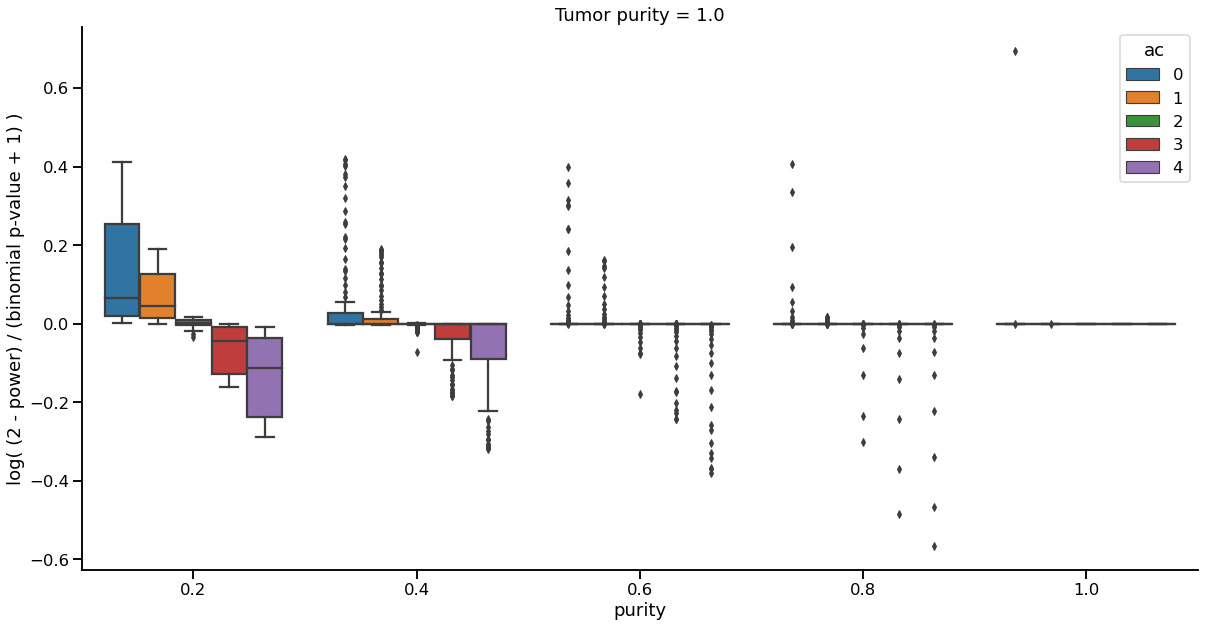

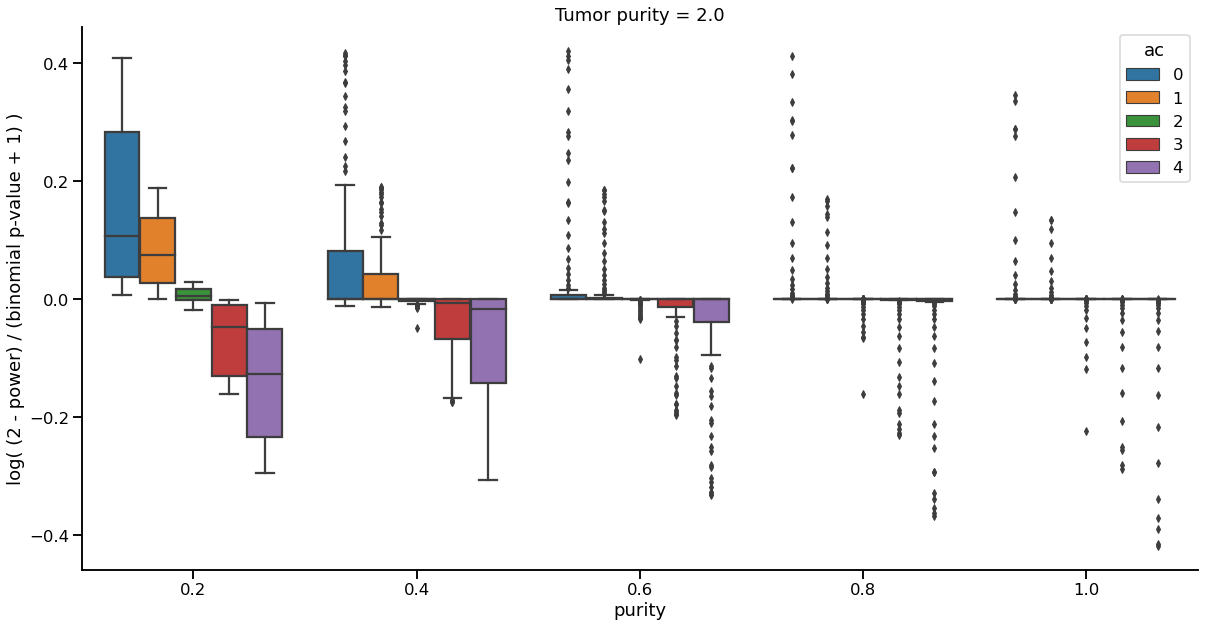

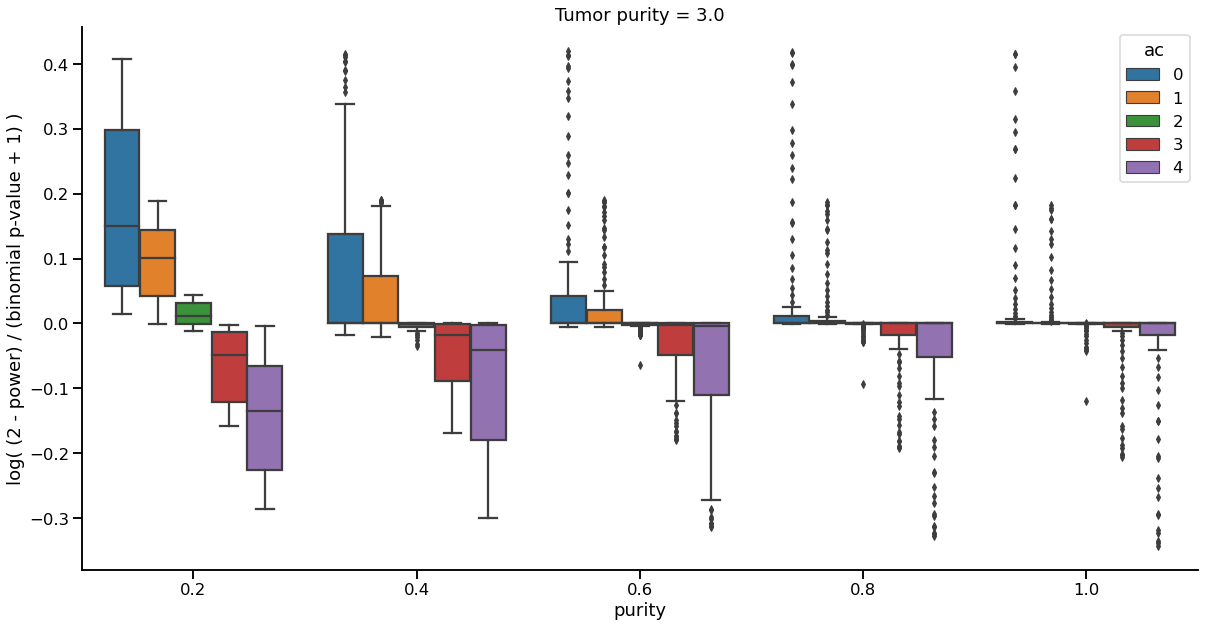

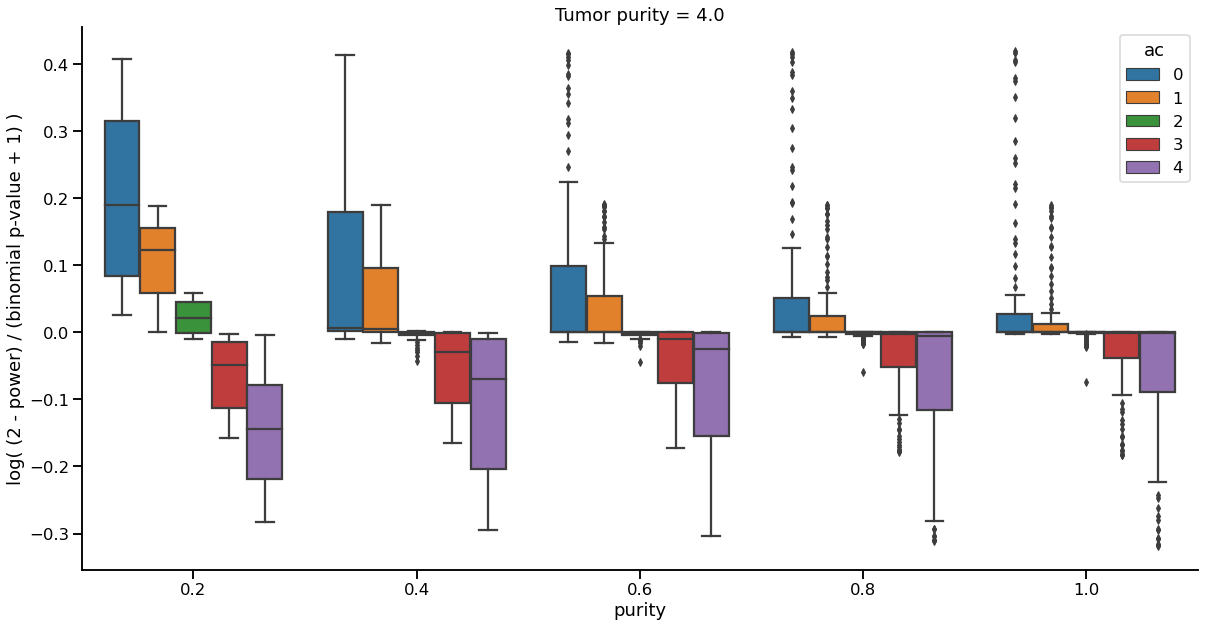

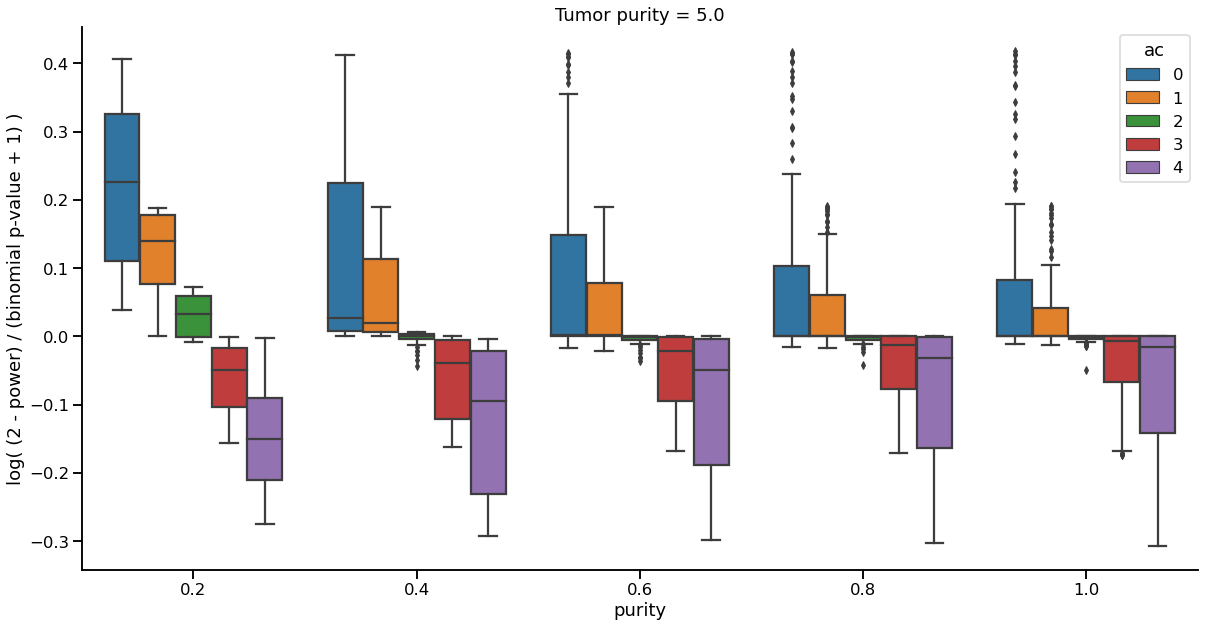

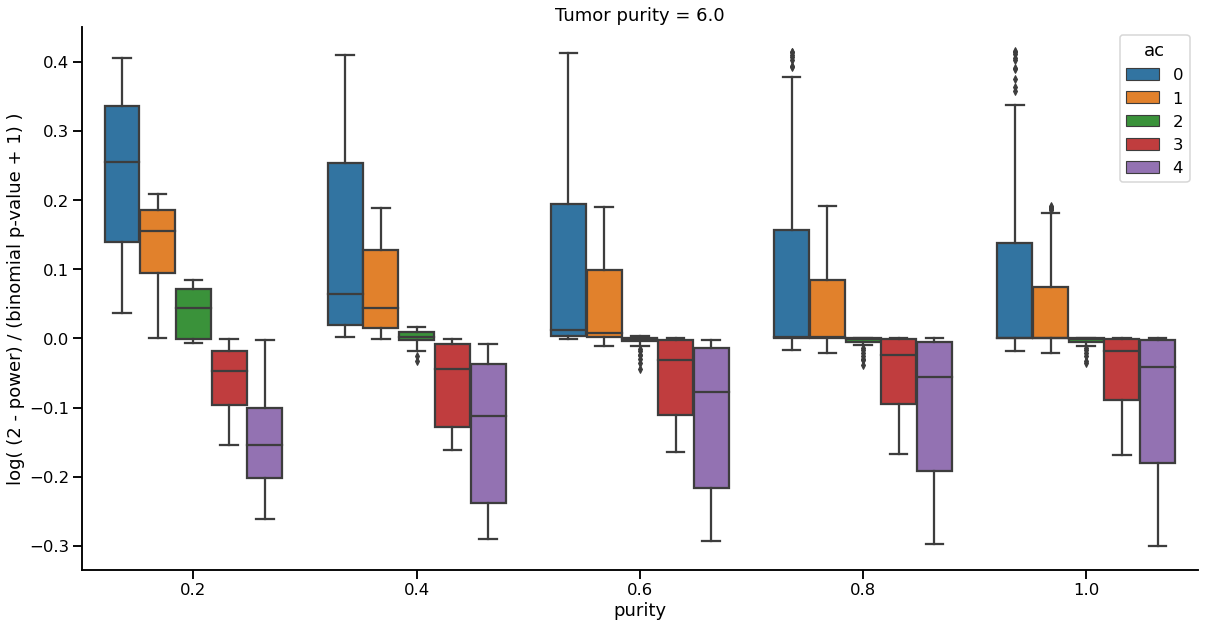

In [87]:
data['ratio'] = data[['reversed_power', 'pvalue']].apply(lambda x: np.log((x[0] + 1)/(x[1] + 1)), axis=1)

for ploidy in data.ploidy.unique():

    fig = plt.figure(figsize=(20,10))

    g = sns.boxplot(
        data=data[data.ploidy == ploidy],
        y='ratio', 
        x='purity',
        hue='ac'
    )
    plt.title("Tumor purity = {}".format(ploidy))
    plt.ylabel("log( (2 - power) / (binomial p-value + 1) )")
    sns.despine()
    plt.savefig("../figures/comparison_power_probability_boxplot_ploidy_{}.png".format(ploidy), dpi='figure')